# Setup

### Importing Dependencies and Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

df = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv', sep=',')

X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

print(X.shape)
print(y.shape)

(253680, 21)
(253680,)


### Implementing functions

In [2]:
def report_info(y_test, y_pred, test_set_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('\nTest set:', test_set_name)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('recall:', recall)
    print('f1:', f1)

    cm1 = confusion_matrix(y_test,y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=cm1,show_absolute=True,show_normed=True, colorbar=True)
    ax.set_title('\nConfusion Matrix for ' + test_set_name + ' test set')
    plt.show()

# Part 1: Demonstrating the Problem  
I'll illustrate this for our logistic regression model but it holds true for every approach we used since the problem is with the train and test distribution.


Test set: unbalanced
Accuracy: 0.865874329864396
Precision: 0.5451977401129944
recall: 0.16549949978562242
f1: 0.25391952636772286


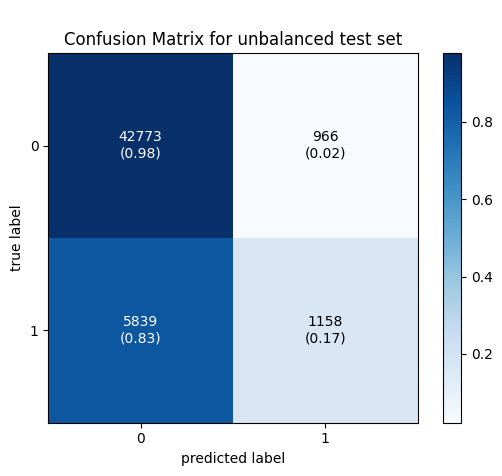

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_demo_model = LogisticRegression(random_state=42)
log_demo_model.fit(X_train_scaled, y_train)

y_pred = log_demo_model.predict(X_test_scaled)

report_info(y_test, y_pred, 'unbalanced')


Test set: balanced
Accuracy: 0.5718879519794198
Precision: 0.8839694656488549
recall: 0.16549949978562242
f1: 0.2788010111953774


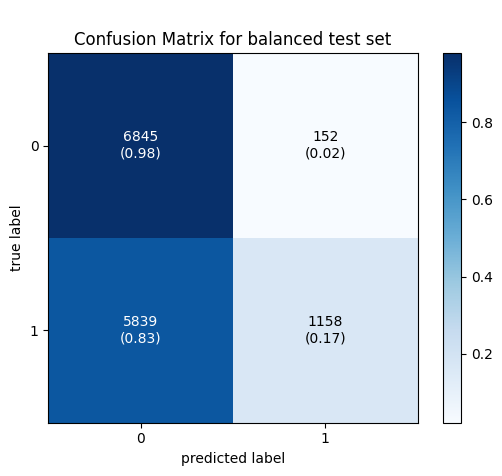

In [4]:
undersample = RandomUnderSampler(sampling_strategy="majority")
X_test_resampled, y_test_resampled = undersample.fit_resample(X_test_scaled, y_test)

y_pred_resampled = log_demo_model.predict(X_test_resampled)

report_info(y_test_resampled, y_pred_resampled, 'balanced')

Balanced accuracy is much worse suggesting that the model was over-fitting on the distribution of the data rather than the features.

# Part 2: Balancing the Training Dataset

### Data Preparation

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

undersample = RandomUnderSampler()
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
print(y_train_under.value_counts())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_under)
X_test_scaled = scaler.transform(X_test)

# Test sets to verify how the models perform on different distributions. 
# If the model is learning from the features rather than the distribution, we should expect more consistent performance across the test sets.
undersample_imbalance_positive = RandomUnderSampler(sampling_strategy={0: 300, 1: 3000})
undersample_imbalance_negative = RandomUnderSampler(sampling_strategy={0: 3000, 1: 300})

X_test_positive_imbalance, y_test_positive_imbalance = undersample_imbalance_positive.fit_resample(X_test_scaled, y_test)
X_test_negative_imbalance, y_test_negative_imbalance = undersample_imbalance_negative.fit_resample(X_test_scaled, y_test)

print(y_test_positive_imbalance.value_counts())
print(y_test_negative_imbalance.value_counts())

Diabetes_binary
0.0    28349
1.0    28349
Name: count, dtype: int64
Diabetes_binary
1.0    3000
0.0     300
Name: count, dtype: int64
Diabetes_binary
0.0    3000
1.0     300
Name: count, dtype: int64


# Part 3: Re-implementing Models with Corrected Dataset

### Logistic Regression


Test set: balanced
Accuracy: 0.7301915799432356
Precision: 0.30969173017859175
recall: 0.7781906531370587
f1: 0.443061149761992


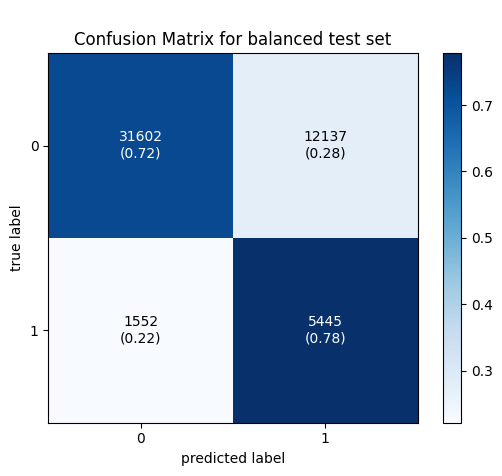


Test set: positively imbalanced
Accuracy: 0.7672727272727272
Precision: 0.9630705394190872
recall: 0.7736666666666666
f1: 0.8580406654343807


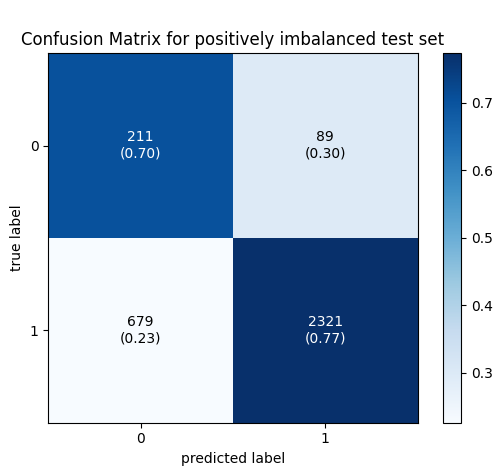


Test set: negatively imbalanced
Accuracy: 0.723939393939394
Precision: 0.2240289069557362
recall: 0.8266666666666667
f1: 0.35252309879175553


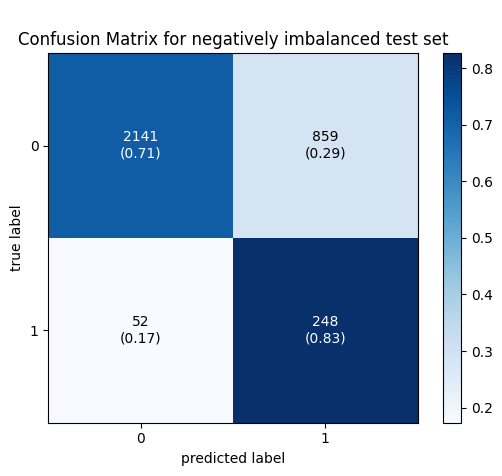

Logistic Regression Accuracy: 0.745282036061715


In [6]:
from sklearn.model_selection import cross_val_score

log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_scaled, y_train_under)

y_pred = log_model.predict(X_test_scaled)
report_info(y_test, y_pred, 'balanced')

y_pred_positive_imbalance = log_model.predict(X_test_positive_imbalance)
report_info(y_test_positive_imbalance, y_pred_positive_imbalance, 'positively imbalanced')

y_pred_negative_imbalance = log_model.predict(X_test_negative_imbalance)
report_info(y_test_negative_imbalance, y_pred_negative_imbalance, 'negatively imbalanced')

# k-fold cross-validation
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
cv_scores = cross_val_score(log_model, X_train_scaled, y_train_under, cv=kfold)
logistic_accuracy = cv_scores.mean()
print('Logistic Regression Accuracy:', logistic_accuracy)

### Neural Network


Test set: balanced
Accuracy: 0.7126103752759382
Precision: 0.3008821676118463
recall: 0.8189223953122767
f1: 0.44007526592680773


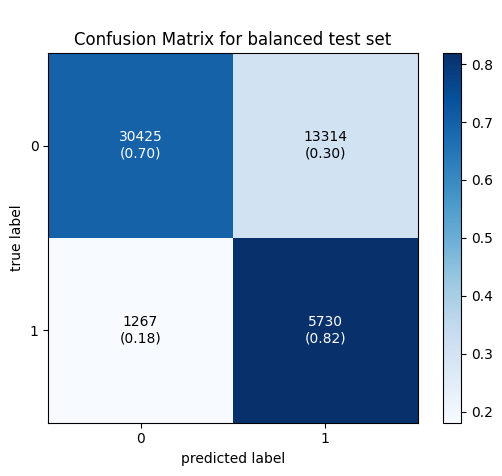


Test set: positively imbalanced
Accuracy: 0.8057575757575758
Precision: 0.9616438356164384
recall: 0.819
f1: 0.8846084608460846


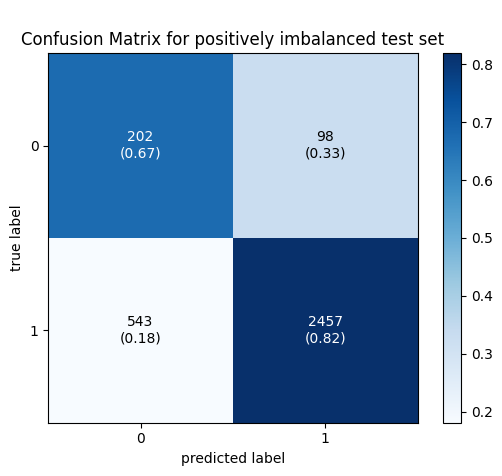


Test set: negatively imbalanced
Accuracy: 0.7027272727272728
Precision: 0.21553884711779447
recall: 0.86
f1: 0.34468937875751504


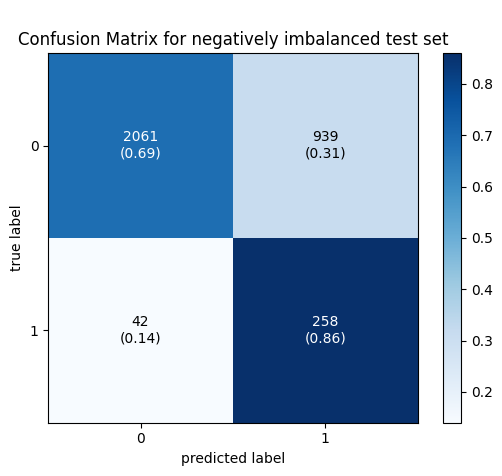

Neural Network Accuracy: 0.7520019332220191


In [7]:
nn_model = MLPClassifier(hidden_layer_sizes=[7], max_iter=1000, random_state=42)
nn_model.fit(X_train_scaled, y_train_under)

y_pred = nn_model.predict(X_test_scaled)
report_info(y_test, y_pred, 'balanced')
nn_accuracy = accuracy_score(y_test, y_pred)

y_pred_positive_imbalance = nn_model.predict(X_test_positive_imbalance)
report_info(y_test_positive_imbalance, y_pred_positive_imbalance, 'positively imbalanced')

y_pred_negative_imbalance = nn_model.predict(X_test_negative_imbalance)
report_info(y_test_negative_imbalance, y_pred_negative_imbalance, 'negatively imbalanced')

cv_scores = cross_val_score(nn_model, X_train_scaled, y_train_under, cv=kfold)
nn_accuracy = cv_scores.mean()
print('Neural Network Accuracy:', nn_accuracy)

### Decision Tree


Test set: balanced
Accuracy: 0.6603595080416272
Precision: 0.23703817892194645
recall: 0.6592825496641418
f1: 0.34870360571471765


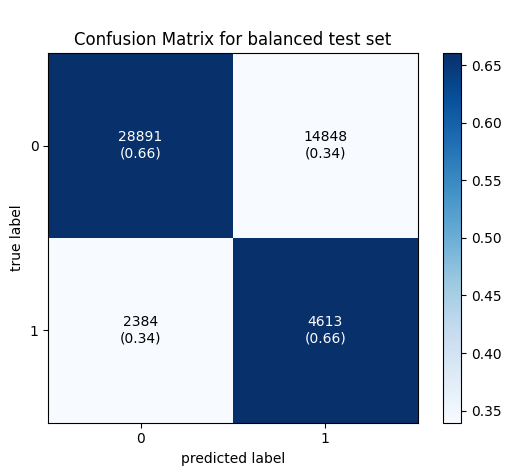


Test set: positively imbalanced
Accuracy: 0.6633333333333333
Precision: 0.9547424169475205
recall: 0.661
f1: 0.7811699822729959


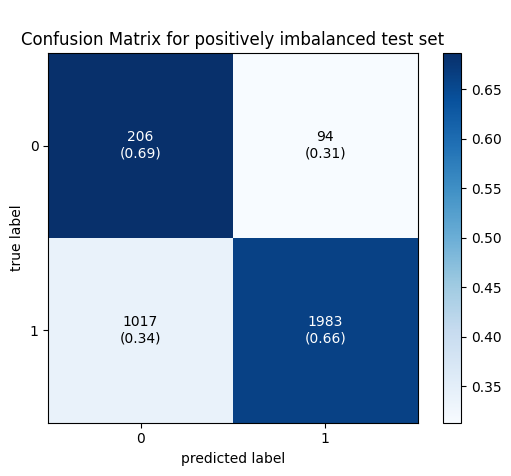


Test set: negatively imbalanced
Accuracy: 0.6527272727272727
Precision: 0.15441176470588236
recall: 0.63
f1: 0.24803149606299216


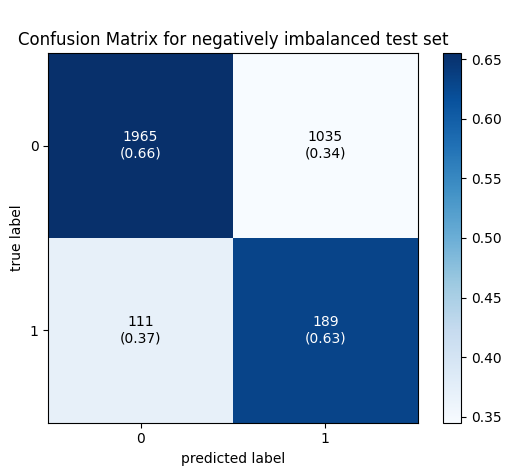

Decision Tree Accuracy: 0.6566370710099763


In [8]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model = dt_model.fit(X_train_scaled, y_train_under)

y_predict = dt_model.predict(X_test_scaled)
report_info(y_test, y_predict, 'balanced')
dt_accuracy = accuracy_score(y_test, y_predict)

y_pred_positive_imbalance = dt_model.predict(X_test_positive_imbalance)
report_info(y_test_positive_imbalance, y_pred_positive_imbalance, 'positively imbalanced')

y_pred_negative_imbalance = dt_model.predict(X_test_negative_imbalance)
report_info(y_test_negative_imbalance, y_pred_negative_imbalance, 'negatively imbalanced')

cv_scores = cross_val_score(dt_model, X_train_scaled, y_train_under, cv=kfold)
dt_accuracy = cv_scores.mean()
print('Decision Tree Accuracy:', dt_accuracy)

### SVM


Test set: balanced
Accuracy: 0.7074463891516871
Precision: 0.2961018711018711
recall: 0.8142060883235672
f1: 0.4342722109997332


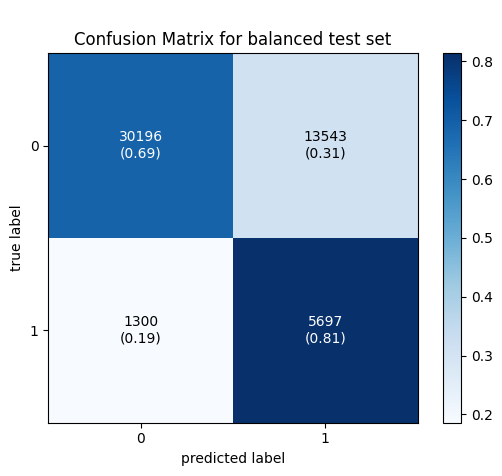


Test set: positively imbalanced
Accuracy: 0.796969696969697
Precision: 0.9604743083003953
recall: 0.81
f1: 0.8788426763110307


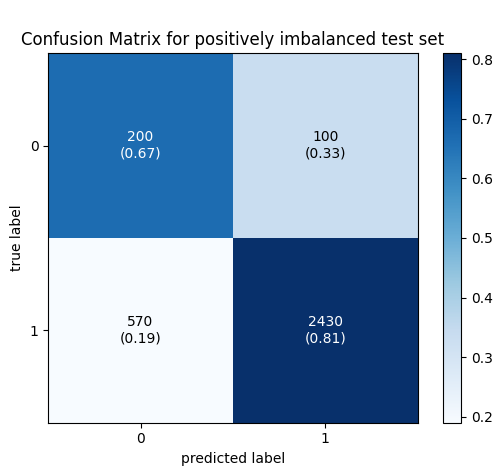


Test set: negatively imbalanced
Accuracy: 0.7006060606060606
Precision: 0.21140939597315436
recall: 0.84
f1: 0.3378016085790885


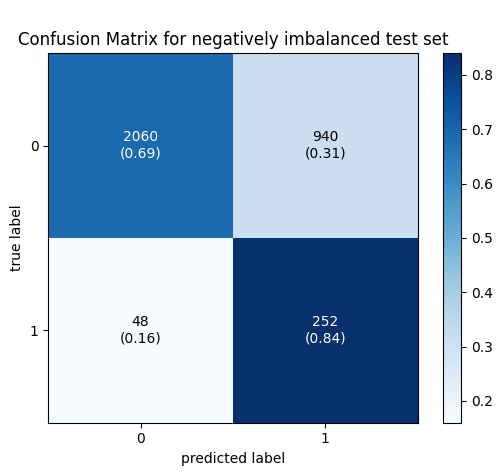

Support Vector Machine Accuracy: 0.7489330101548599


In [9]:
svm_model = SVC(random_state=42)
svm_model.fit(X_train_scaled, y_train_under)

y_pred = svm_model.predict(X_test_scaled)
report_info(y_test, y_pred, 'balanced')
svm_accuracy = accuracy_score(y_test, y_pred)

y_pred_positive_imbalance = svm_model.predict(X_test_positive_imbalance)
report_info(y_test_positive_imbalance, y_pred_positive_imbalance, 'positively imbalanced')

y_pred_negative_imbalance = svm_model.predict(X_test_negative_imbalance)
report_info(y_test_negative_imbalance, y_pred_negative_imbalance, 'negatively imbalanced')

cv_scores = cross_val_score(svm_model, X_train_scaled, y_train_under, cv=kfold)
svm_accuracy = cv_scores.mean()
print('Support Vector Machine Accuracy:', svm_accuracy)

Text(0.5, 1.0, 'Mean Model Accuracy')

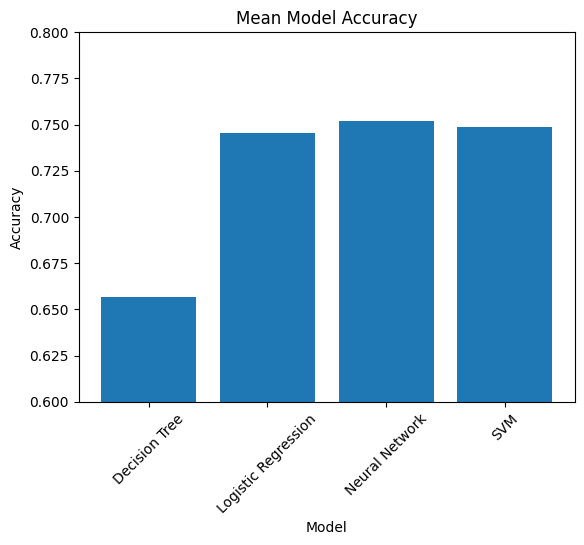

In [12]:
# Results of KFold for DT, LR, NN, SVM
accuracies = [dt_accuracy, logistic_accuracy, nn_accuracy, svm_accuracy]

plt.bar(['Decision Tree', 'Logistic Regression', 'Neural Network', 'SVM'], accuracies)
plt.xticks(rotation=45)
plt.ylim(0.6, 0.8)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Mean Model Accuracy')